<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.b.isolation-forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import average_precision_score, precision_score, \
                        recall_score, precision_recall_curve, roc_curve, \
                        roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle



# I prepared these libraries for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from andrea_models import subsample
from visualization import silhouette_diagram, plot_conf_mat, \
                      false_positive_rate, evaluate_anomaly_detector



# To show time at each cell
# Credits to https://medium.com/@arptoth/how-to-measure-execution-time-in-google-colab-707cc9aad1c8
!pip install ipython-autotime 
%load_ext autotime

--2020-04-03 15:53:48--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [text/plain]
Saving to: ‘andrea_models.py’

andrea_models.py    100%[===================>]   3.12K  --.-KB/s    in 0s      

2020-04-03 15:53:48 (49.4 MB/s) - ‘andrea_models.py’ saved [3190/3190]

--2020-04-03 15:53:51--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request s

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=4232196b0bda4feec3541d7712982f4dbf52c1841c0d821c6d6b94a7c9c9b3f5
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


The following code is the same as in the [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.a.kmeans-anomaly.ipynb).

In [23]:
help(evaluate_anomaly_detector)

Help on function evaluate_anomaly_detector in module __main__:

evaluate_anomaly_detector(y_train, anomaly_scores)

time: 2.42 ms


In [7]:
np.random.seed(9)
random.seed(9)

! wget https://datahub.io/machine-learning/creditcard/r/creditcard.csv

df = pd.read_csv('creditcard.csv')
df.head()

df.info(verbose=True)
df['Class'].value_counts()
num_of_normal = sum( df['Class']=="'0'" )
num_of_anomalies = sum( df['Class']=="'1'" )
num_of_anomalies/num_of_normal

df = df.drop('Time', axis=1)
X = df.drop('Class', axis=1)
y = [1 if c=="'1'" else 0 for c in df['Class']] 

--2020-04-03 15:55:59--  https://datahub.io/machine-learning/creditcard/r/creditcard.csv
Resolving datahub.io (datahub.io)... 104.18.49.253, 104.18.48.253, 2606:4700:3033::6812:31fd, ...
Connecting to datahub.io (datahub.io)|104.18.49.253|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv [following]
--2020-04-03 15:56:01--  https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 104.18.49.253, 104.18.48.253, 2606:4700:3031::6812:30fd, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|104.18.49.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151114991 (144M) [text/csv]
Saving to: ‘creditcard.csv’

creditcard.csv      100%[===================>] 144.11M   134MB/s    in 1

Differently than KMeans, isolation forests do not need any scaling.

# Tune the Precision-Recall curve and the ROC curve

We will apply isolation forests on the credit card fraud dataset, already used in the [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.a.kmeans-anomaly.ipynb). A similar notebook can be found in [Kaggle](https://www.kaggle.com/amarnayak/testing-isolation-forest-for-fraud-detection). 

 As in the [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.a.kmeans-anomaly.ipynb), we separate training and test set.

In [8]:
X, y = shuffle(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
model = IsolationForest()

time: 300 ms


In [0]:
help(evaluate_anomaly_detector)

Our approach is unsupervised, so we **don't use y into fit(..)**

In [9]:
model.fit(X_train)
anomaly_scores = - model.decision_function(X_train)

time: 7.87 s


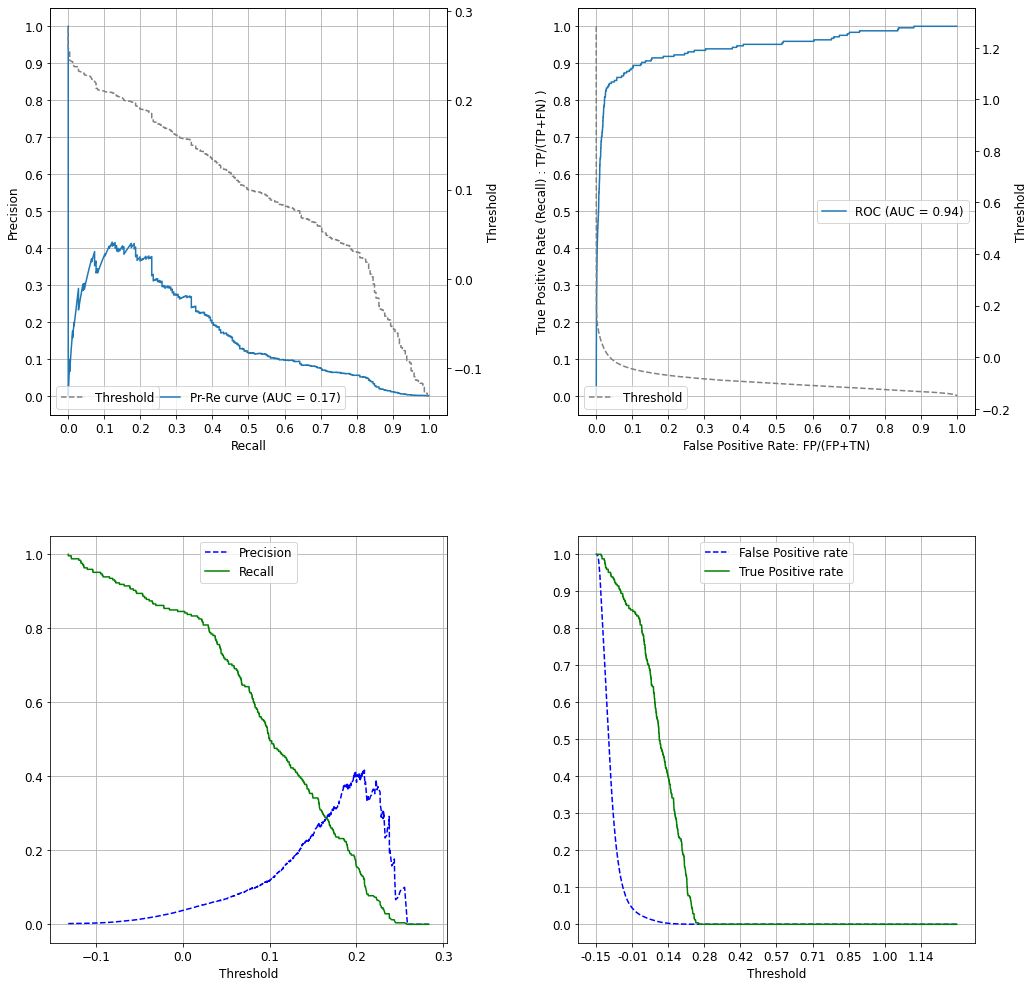

time: 1.51 s


In [10]:
evaluate_anomaly_detector(y_train, anomaly_scores)

Our isolation tree is still bad. The AUC of the precision-recall and ROC curves can be improved

In [0]:
help(evaluate_anomaly_detector)

Create a function to put all these evaluations together

In [11]:
def evaluate_anomaly_detector(y_train, anomaly_scores):
  precision, recall, thresholds = precision_recall_curve(y_train, anomaly_scores)
  plt.plot(recall, precision)
  plt.ylabel('Precision')
  plt.xlabel('Recall')

  auc_score = average_precision_score(y_train,anomaly_scores)
  print("Area under the precision-recall curve:", auc_score)

  return precision, recall, thresholds, auc_score

time: 5.67 ms


### Number of trees

Increasing the number of trees always improves performance

In [12]:
model = IsolationForest(n_estimators=500)
model.fit(X_train)


IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=500,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

time: 10.5 s


In [0]:
help(evaluate_anomaly_detector)

Area under the precision-recall curve: 0.16061742847406832


(array([0.00201562, 0.00200744, 0.00200746, ..., 0.        , 0.        ,
        1.        ]),
 array([1.        , 0.99593496, 0.99593496, ..., 0.        , 0.        ,
        0.        ]),
 array([-0.13603157, -0.13603122, -0.13603109, ...,  0.25744372,
         0.25888364,  0.27462814]),
 0.16061742847406832)

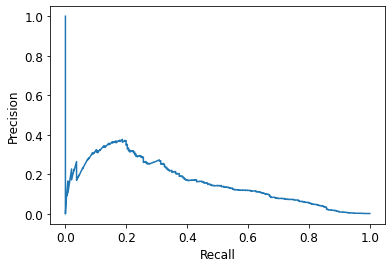

time: 29.3 s


In [13]:
anomaly_scores = -model.decision_function(X_train)
evaluate_anomaly_detector(y_train, anomaly_scores)

### Others

GridSearch from `sklearn` is not simple (however not impossible) to apply. It is more simple to make a grid search manually

In [14]:
iforest = IsolationForest(n_estimators=500)

for max_features in [1, 15, 29]:
  for max_samples in range(256, X_train.shape[0], int(X_train.shape[0] / 3) ):
    model = IsolationForest(n_estimators=500, max_features=max_features,
                            max_samples = max_samples)
    model.fit(X_train)
    anomaly_scores = -model.decision_function(X_train)
    auc_score = average_precision_score(y_train, anomaly_scores)
    print("max_fetaures:", max_features, "; max_samples:", max_samples, 
          "auc_score:", auc_score)

max_fetaures: 1 ; max_samples: 256 auc_score: 0.1554807662884762
max_fetaures: 1 ; max_samples: 47723 auc_score: 0.20355469917939423
max_fetaures: 1 ; max_samples: 95190 auc_score: 0.1956571483808927
max_fetaures: 15 ; max_samples: 256 auc_score: 0.15042149906743724
max_fetaures: 15 ; max_samples: 47723 auc_score: 0.22126354642389168
max_fetaures: 15 ; max_samples: 95190 auc_score: 0.23036654280846913
max_fetaures: 29 ; max_samples: 256 auc_score: 0.13996559969003916
max_fetaures: 29 ; max_samples: 47723 auc_score: 0.22654100539764696
max_fetaures: 29 ; max_samples: 95190 auc_score: 0.23050696911613683
time: 7min 3s


Let's evaluate the best configuration we found

Area under the precision-recall curve: 0.22825294646380814


(array([0.00213412, 0.00212546, 0.00212548, ..., 0.        , 0.        ,
        1.        ]),
 array([1.        , 0.99593496, 0.99593496, ..., 0.        , 0.        ,
        0.        ]),
 array([-0.17844069, -0.17844032, -0.17843993, ...,  0.31689548,
         0.31791311,  0.36068837]),
 0.22825294646380814)

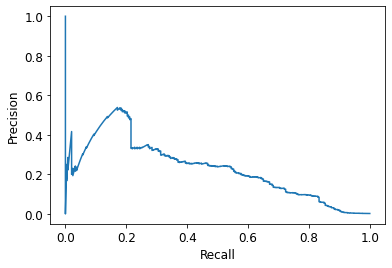

time: 54.9 s


In [15]:
n_estimators=500
max_features = 29
max_samples = 47723

model = IsolationForest(n_estimators=n_estimators, max_features=max_features,
                        max_samples=max_samples)

model.fit(X_train)
anomaly_scores = -model.decision_function(X_train)
evaluate_anomaly_detector(y_train, anomaly_scores)

In [0]:
help(evaluate_anomaly_detector)

Note that `auc_score` is different, since isolation forests have a lot of randomness.

No real improvement. Increase further the number of trees.

In [16]:
n_estimators = 1500

model = IsolationForest(n_estimators=n_estimators, max_features=max_features,
                        max_samples=max_samples)

model.fit(X_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=29, max_samples=47723, n_estimators=1500,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

time: 53.5 s


In [17]:

anomaly_scores = -model.decision_function(X_train)

time: 1min 52s


Area under the precision-recall curve: 0.2196836243580709


(array([0.00205804, 0.00204969, 0.00204971, ..., 0.        , 0.        ,
        1.        ]),
 array([1.        , 0.99593496, 0.99593496, ..., 0.        , 0.        ,
        0.        ]),
 array([-0.17885654, -0.1788565 , -0.1788564 , ...,  0.31561594,
         0.31615941,  0.3591071 ]),
 0.2196836243580709)

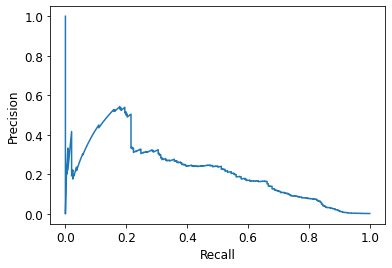

time: 335 ms


In [18]:
evaluate_anomaly_detector(y_train, anomaly_scores)

In [0]:
help(evaluate_anomaly_detector)

# Fix the threshold

A good threshold could be:

In [21]:
help(evaluate_anomaly_detector)

Help on function evaluate_anomaly_detector in module __main__:

evaluate_anomaly_detector(y_train, anomaly_scores)

time: 2.81 ms


In [22]:
threshold_selected = -0.15

evaluate_anomaly_detector(y_train, anomaly_scores, 
                          threshold_selected=threshold_selected)

TypeError: ignored

time: 18.5 ms


But the false positive rate is too high. We need to renounce to some recall

In [0]:
threshold_selected = -0.115

evaluate_anomaly_detector(y_train, anomaly_scores, threshold_selected)

With this choice
* We find 84% of frauds
* We raise false alarms for 2% of normal activities

# Test


In [0]:
model.fit(X_test)
an_scores = -model.decision_function(X_test)

In [0]:
y_pred = (an_scores >= threshold_selected)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr = false_positive_rate(y_test, y_pred)

print("precision=", precision)
print('recall=', recall)
print('false positive rate=', fpr)


In [0]:
class_names= np.array( ['normal', 'anomaly'] )
plot_conf_mat(y_test, y_pred, class_names)

# Todo

Check:
* https://medium.com/datadriveninvestor/credit-card-fraud-detection-using-local-outlier-factor-and-isolation-forest-in-python-56edd0a44af5
* https://medium.com/learningdatascience/anomaly-detection-techniques-in-python-50f650c75aaf